# UIUC Solar Power with Echo State Networks

This notebook uses an Echo State Network(ESN) (from ``pyESN``) to predict
the electricity produced by the solar farm at the University of Illinois.
All predictions in this notebook are optimized for 72 hour predictions. The
parameters will not generalize well to other prediction lengths because they
are optimized by looking at the mean squared error over the entire prediction
window.
In the future, the specific reactor design will motivate the size of the prediction
window.


The following items are included:
1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

### 1. Initial Demonstration

In [1]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# custom libraries
from tools import MSE
from pyESN.pyESN import ESN

In [31]:
# import demand data
dataframe = pd.read_csv("data/solarfarm_data.csv", usecols=['time','power_data'])
solarpower = np.array(dataframe.power_data).astype('float64')

# normalize
norm = np.linalg.norm(solarpower)
solarpower_norm = solarpower/norm

In [3]:
tic = time.perf_counter()
n_reservoir= 1000
sparsity=0.1
rand_seed=85
spectral_radius = 1.5
# for regularization
noise = .0001


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 8000
futureTotal=72
pred_tot=np.zeros(futureTotal)

# train the ESN
pred_training = esn.fit(np.ones(trainlen),solarpower_norm[-trainlen-futureTotal:-futureTotal])
solarpower_pred = esn.predict(np.ones(futureTotal))

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

This simulation took 2.5 seconds.
This simulation took 0.041 minutes.


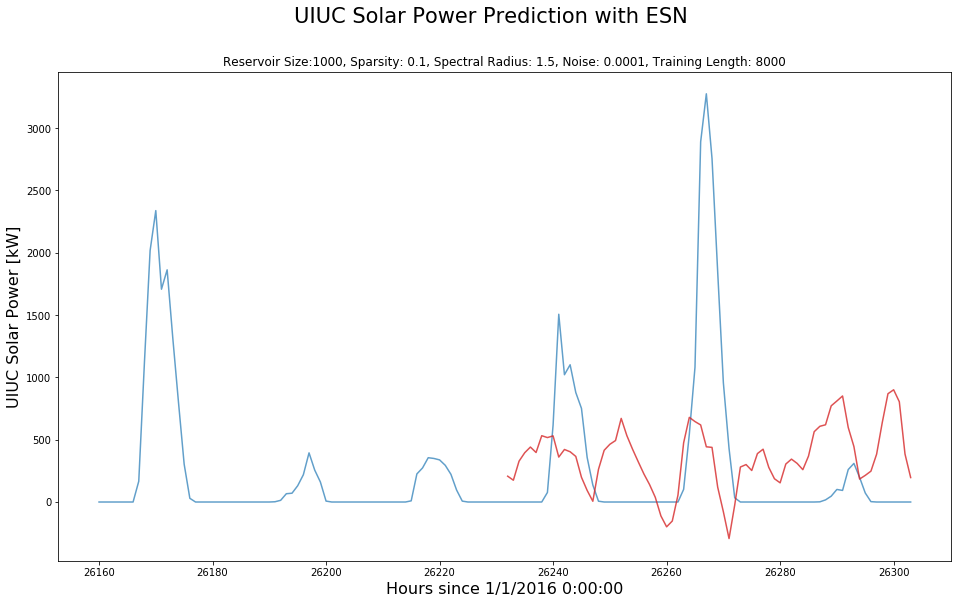

In [4]:
time_range = np.arange(0,len(solarpower),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Solar Power [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(time_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time_range[-futureTotal:], norm*solarpower_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

In [5]:
tic = time.perf_counter()
n_reservoir= 1000
sparsity=0.1
rand_seed=85

radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 8000
future = 1
futureTotal= 72

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
              n_outputs = 1, 
              n_reservoir = n_reservoir,
              sparsity=sparsity,
              random_state=rand_seed,
              spectral_radius = rho,
              noise=noise)

        pred_training = esn.fit(np.ones(trainlen),solarpower_norm[-trainlen-futureTotal:-futureTotal])
        solarpower_pred = esn.predict(np.ones(futureTotal))
        
        loss[l, j] = MSE(solarpower_pred, solarpower_norm[-futureTotal:])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] )

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

rho =  0.5 , noise =  0.0001 , MSE =  0.004557388514435138
rho =  0.5 , noise =  0.0003 , MSE =  0.0039768289644736415
rho =  0.5 , noise =  0.0007 , MSE =  0.003609839854449636
rho =  0.5 , noise =  0.001 , MSE =  0.003552339609888937
rho =  0.5 , noise =  0.003 , MSE =  0.0035249543714466368
rho =  0.5 , noise =  0.005 , MSE =  0.0035682810933037714
rho =  0.5 , noise =  0.007 , MSE =  0.0036264317148004374
rho =  0.5 , noise =  0.01 , MSE =  0.0037113220293356003
rho =  0.7 , noise =  0.0001 , MSE =  0.004096183561752139
rho =  0.7 , noise =  0.0003 , MSE =  0.0038277950817348317
rho =  0.7 , noise =  0.0007 , MSE =  0.003465769321832191
rho =  0.7 , noise =  0.001 , MSE =  0.0033987992300052385
rho =  0.7 , noise =  0.003 , MSE =  0.0033812439470129593
rho =  0.7 , noise =  0.005 , MSE =  0.0034146893985424107
rho =  0.7 , noise =  0.007 , MSE =  0.0034533108076694368
rho =  0.7 , noise =  0.01 , MSE =  0.003518233652219522
rho =  0.9 , noise =  0.0001 , MSE =  0.003182979509004227

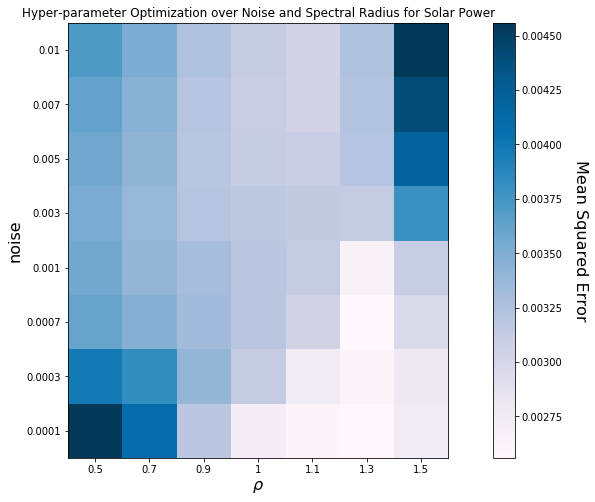

In [6]:
plt.figure(figsize=(16,8))
plt.title("Hyper-parameter Optimization over Noise and Spectral Radius for Solar Power")
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuBu')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$', fontsize=16); plt.ylabel('noise', fontsize=16); 
# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 
cb.set_label(label="Mean Squared Error", fontsize=16, rotation=-90, labelpad=25);

In [7]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1.3 
noise =  0.0001 
MSE =  0.002559910874545542


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

In [8]:
tic = time.perf_counter()
rho = rho_opt
noise = noise_opt
rand_seed=85

reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

reservoir_set_size  = len(reservoir_set)
sparsity_set_size = len(sparsity_set)

trainlen = 8000
future = 1
futureTotal= 72

loss = np.zeros([reservoir_set_size, sparsity_set_size])

for l in range(reservoir_set_size):
    n_reservoir = reservoir_set[l]
    for j in range(sparsity_set_size):
        sparsity = sparsity_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
              n_outputs = 1, 
              n_reservoir = n_reservoir,
              sparsity=sparsity,
              random_state=rand_seed,
              spectral_radius = rho,
              noise=noise)

        pred_training = esn.fit(np.ones(trainlen),solarpower_norm[-trainlen-futureTotal:-futureTotal])
        solarpower_pred = esn.predict(np.ones(futureTotal))
        
        loss[l, j] = MSE(solarpower_pred, solarpower_norm[-futureTotal:])        
        print('n_reservoir = ', reservoir_set[l], ', sparsity = ', sparsity_set[j], ', MSE = ', loss[l][j] )
        
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02} seconds.")
print(f"This simulation took {elapsed/60:0.02} minutes.")

n_reservoir =  600 , sparsity =  0.005 , MSE =  0.003005971657759844
n_reservoir =  600 , sparsity =  0.01 , MSE =  0.0027321563170109604
n_reservoir =  600 , sparsity =  0.03 , MSE =  0.0028190528288102074
n_reservoir =  600 , sparsity =  0.05 , MSE =  0.002958263517391476
n_reservoir =  600 , sparsity =  0.1 , MSE =  0.0027769739831787514
n_reservoir =  600 , sparsity =  0.15 , MSE =  0.0028467876661778255
n_reservoir =  600 , sparsity =  0.2 , MSE =  0.0025667162760728665
n_reservoir =  800 , sparsity =  0.005 , MSE =  0.0031653464838206167
n_reservoir =  800 , sparsity =  0.01 , MSE =  0.003162105747866929
n_reservoir =  800 , sparsity =  0.03 , MSE =  0.002490262168573343
n_reservoir =  800 , sparsity =  0.05 , MSE =  0.002781914935269743
n_reservoir =  800 , sparsity =  0.1 , MSE =  0.002908277705054802
n_reservoir =  800 , sparsity =  0.15 , MSE =  0.002547161237673031
n_reservoir =  800 , sparsity =  0.2 , MSE =  0.0029992148868328394
n_reservoir =  1000 , sparsity =  0.005 , M

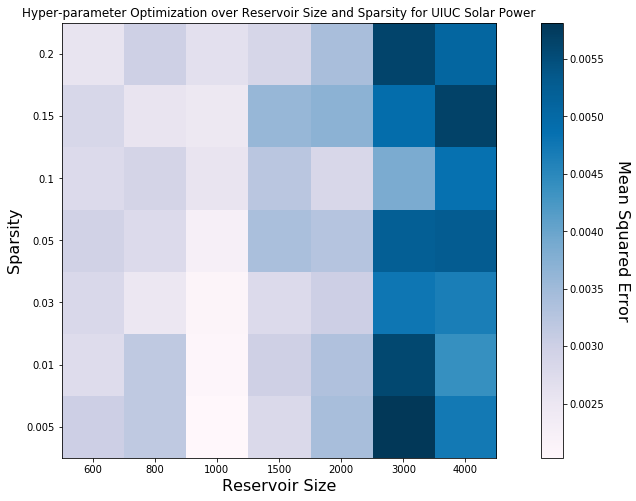

In [9]:
plt.figure(figsize=(16,8))
plt.title("Hyper-parameter Optimization over Reservoir Size and Sparsity for UIUC Solar Power")
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuBu')
plt.xticks(np.linspace(0,reservoir_set_size-1,reservoir_set_size), reservoir_set);
plt.yticks(np.linspace(0,sparsity_set_size-1, sparsity_set_size), sparsity_set);
plt.xlabel(r'Reservoir Size', fontsize=16); plt.ylabel('Sparsity', fontsize=16); 
# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 
cb.set_label(label="Mean Squared Error", fontsize=16, rotation=-90, labelpad=25);

In [10]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
n_opt = reservoir_set[int(index_min[0])]
s_opt = sparsity_set[int(index_min[1])]
print('The optimal set is:\nreservoir_size = ',
      n_opt,'\nsparsity = ',s_opt,'\nMSE = ',minLoss)

The optimal set is:
reservoir_size =  1000 
sparsity =  0.005 
MSE =  0.002028291294963571


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

In [11]:
tic = time.perf_counter()
# optimal set of n_reservoir and sparsity
n_reservoir= n_opt
sparsity = s_opt

# optimal set of spectral_radius and noise
spectral_radius = rho_opt
# for regularization
noise = noise_opt

rand_seed=85

trainingLengths = np.arange(4000,25000,300)
futureTotal=72

loss_k = np.zeros(len(trainingLengths))

for l in range(len(trainingLengths)):
    trainlen = trainingLengths[l]   

    esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = spectral_radius,
          noise=noise)


    pred_training = esn.fit(np.ones(trainlen),solarpower_norm[-trainlen-futureTotal:-futureTotal])
    solarpower_pred = esn.predict(np.ones(futureTotal))
        
    loss_k[l] = MSE(solarpower_pred, solarpower_norm[-futureTotal:]) 
    
    print(f"Training length = {trainlen}, MSE = {loss_k[l]}")
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

Training length = 4000, MSE = 0.003250608673184734
Training length = 4300, MSE = 0.002579700152582367
Training length = 4600, MSE = 0.002855110528153759
Training length = 4900, MSE = 0.002897203879246326
Training length = 5200, MSE = 0.002579704152884111
Training length = 5500, MSE = 0.0028314538787786903
Training length = 5800, MSE = 0.0023683355647831027
Training length = 6100, MSE = 0.0026944452024358764
Training length = 6400, MSE = 0.0028569449487658052
Training length = 6700, MSE = 0.002174611932076432
Training length = 7000, MSE = 0.0028215124858720327
Training length = 7300, MSE = 0.0035299672520572997
Training length = 7600, MSE = 0.0026232132675920554
Training length = 7900, MSE = 0.002427059555577513
Training length = 8200, MSE = 0.0034175033213029032
Training length = 8500, MSE = 0.0033527419134702008
Training length = 8800, MSE = 0.0019766141197001927
Training length = 9100, MSE = 0.0024491276252603307
Training length = 9400, MSE = 0.0033553384369329124
Training length = 9

Text(0, 0.5, 'MSE')

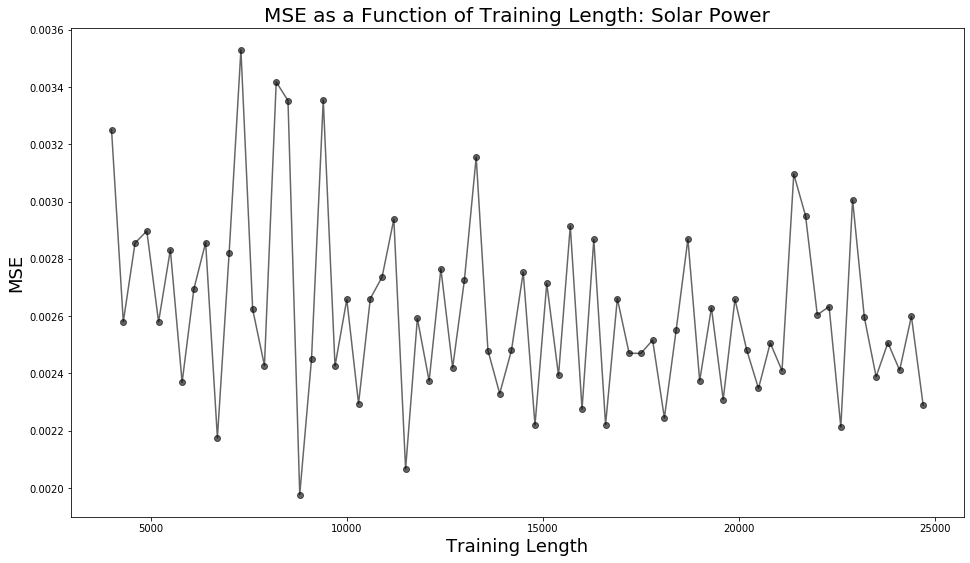

In [12]:
plt.figure(figsize=(16,9))
plt.plot(trainingLengths, loss_k,'-ok', alpha=0.6)
plt.title('MSE as a Function of Training Length: Solar Power', fontsize=20)
plt.xlabel('Training Length', fontsize=18)
plt.ylabel('MSE', fontsize=18)

In [13]:
minloss = np.min(loss_k)
index_min = np.where(loss_k == minloss)
l_opt = trainingLengths[index_min][0]

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: [8800]


### 5. Final Optimized ESN

In [ ]:
n_reservoir= n_opt
# n_reservoir= 2000
# sparsity=0.1
sparsity=s_opt
rand_seed=85
spectral_radius = rho_opt
# for regularization
noise = noise_opt


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

# trainlen = l_opt
trainlen = 26000
futureTotal=72

# train the ESN
pred_training = esn.fit(np.ones(trainlen),solarpower_norm[-trainlen-futureTotal:-futureTotal])
solarpower_pred = esn.predict(np.ones(futureTotal))

In [ ]:
time_range = np.arange(0,len(solarpower),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Solar Power [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(time_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time_range[-futureTotal:], norm*solarpower_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()